# Vanilla Policy Gradients in PyTorch on LunarLander

This notebook is part of **[Edreate.com’s Deep Reinforcement Learning Course](https://edreate.com/courses/deep-reinforcement-learning/)**.  
Here you’ll find the **codebase** used in the lessons.
<p align="left">
  <a href="https://edreate.com/courses/deep-reinforcement-learning/">
    <img src="https://raw.githubusercontent.com/edreate/Brand-Identity-Media/main/Logo/RGB/Logo/SVG/EdReate_Logo.svg" alt="EdReate Logo" width="100"/>
  </a>
</p>

👉 For the **full learning experience** with in-depth writeups, mathematical formulas, video explanations, and structured chapters, visit the course page:

🔗 [https://edreate.com/courses/deep-reinforcement-learning/](https://edreate.com/courses/deep-reinforcement-learning/)

---

### Related Chapters

- [Introduction to Policy Gradients](https://www.edreate.com/courses/deep-reinforcement-learning/policy-gradient-methods/introdcution-to-policy-gradients/)  
- [Vanilla Policy Gradients in PyTorch on LunarLander](https://www.edreate.com/courses/deep-reinforcement-learning/policy-gradient-methods/vanilla-policy-gradients-in-pytorch-on-lunarlander/)

## 1. Gymnasium Environment Setup

In [7]:
import gymnasium as gym
import matplotlib.pyplot as plt

In [8]:
# Initialize environment (discrete actions, RGB rendering mode)
env = gym.make("LunarLander-v3", continuous=True, render_mode="rgb_array")

# --- Observations ---
state, info = env.reset()
n_observations = len(state)

# --- Actions ---
assert hasattr(env.action_space, "shape") and len(env.action_space.shape) == 1, (
    "This script expects a 1D continuous action space."
)
n_actions = env.action_space.shape[0]

print(f"\nEnvironment: LunarLanderContinuous-v3")
print(f"State dimension: {n_observations}")
print(f"Action dimension: {n_actions} (Box[-1, 1])")
print("Initial state:", state)

# --- Data Types (State) ---
print("\nState container type:", type(state))
print("Element data type:", type(state[0]))


Environment: LunarLanderContinuous-v3
State dimension: 8
Action dimension: 2 (Box[-1, 1])
Initial state: [-0.00158691  1.4001431  -0.16076365 -0.47898266  0.00184572  0.03641533
  0.          0.        ]

State container type: <class 'numpy.ndarray'>
Element data type: <class 'numpy.float32'>


### Visualize the environment

## 2. Vanilla Policy Gradients Components for Training

### 2.1 Neural Networks

In [9]:
import torch
import torch.nn as nn


class MLP(nn.Module):
    def __init__(self, in_dim: int, hidden_sizes: tuple[int, int], out_dim: int):
        super().__init__()
        h1, h2 = hidden_sizes
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1),
            nn.ReLU(),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Linear(h2, out_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [10]:
class ValueNetwork(nn.Module):
    """State-value function V(s)."""

    def __init__(self, n_observations: int, hidden_sizes: tuple[int, int] = (256, 256)):
        super().__init__()
        self.body = MLP(n_observations, hidden_sizes, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Return shape: (B,) for convenience
        return self.body(x).squeeze(-1)

### 2.2 Gaussian Policy

In [11]:
import numpy as np
from numpy.typing import NDArray
from torch.distributions import Normal


class GaussianPolicy(nn.Module):
    """
    Tanh-squashed Gaussian policy π(a|s) for continuous actions in [-1, 1]^dim.
    Returns both mean and log_std; log_std is clipped for numerical stability.
    """

    def __init__(
        self,
        n_observations: int,
        n_actions: int,
        hidden_sizes: tuple[int, int] = (256, 256),
        log_std_bounds: tuple[float, float] = (-5.0, 2.0),
    ):
        super().__init__()
        self.mu_net = MLP(n_observations, hidden_sizes, n_actions)
        self.log_std = nn.Parameter(torch.zeros(n_actions))
        self.log_std_bounds = log_std_bounds

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        mu = self.mu_net(x)
        log_std = torch.clamp(self.log_std, self.log_std_bounds[0], self.log_std_bounds[1])
        return mu, log_std

    @staticmethod
    def _tanh_squash(z: torch.Tensor) -> torch.Tensor:
        return torch.tanh(z)

    def sample_action_and_log_prob(
        self, s_np: NDArray[np.float32], device: torch.device
    ) -> tuple[NDArray[np.float32], torch.Tensor]:
        """
        Sample action a = tanh(z) with z ~ N(mu, std), and compute log π(a|s)
        including tanh correction.
        Returns (action_np, log_prob_torch).
        """
        s = torch.as_tensor(s_np, dtype=torch.float32, device=device).unsqueeze(
            0
        )  # (1, n_observations)
        mu, log_std = self.forward(s)  # (1, n_actions), (n_actions,)
        std = log_std.exp()
        dist = Normal(mu, std)
        z = dist.rsample()  # reparameterized sample (1, n_actions)
        a = self._tanh_squash(z)  # (1, n_actions)
        # Log prob with tanh correction
        log_prob = dist.log_prob(z).sum(dim=-1) - torch.log(1 - a.pow(2) + 1e-6).sum(
            dim=-1
        )  # (1,)
        return a.squeeze(0).detach().cpu().numpy(), log_prob.squeeze(
            0
        )  # np (n_actions,), torch scalar

    def deterministic_action(
        self, s_np: NDArray[np.float32], device: torch.device
    ) -> NDArray[np.float32]:
        """Mean action (tanh(mu)) for evaluation."""
        s = torch.as_tensor(s_np, dtype=torch.float32, device=device).unsqueeze(0)
        mu, _ = self.forward(s)
        a = torch.tanh(mu)
        return a.squeeze(0).detach().cpu().numpy()

In [12]:
def compute_returns_and_advantages(
    rewards: list[float], values: list[float], dones: list[bool], gamma: float
) -> tuple[NDArray[np.float32], NDArray[np.float32]]:
    """
    Monte Carlo returns with value baseline advantage: A_t = G_t - V(s_t)
    """
    rewards_array = np.asarray(rewards, dtype=np.float32)
    values_array = np.asarray(values, dtype=np.float32)
    dones_array = np.asarray(dones, dtype=np.bool_)

    returns: list[float] = []
    discounted_return = 0.0

    for r, d in zip(reversed(rewards_array), reversed(dones_array)):
        if d:
            discounted_return = 0.0
        discounted_return = r + gamma * discounted_return

        returns.append(discounted_return)

    returns.reverse()
    returns_np = np.asarray(returns, dtype=np.float32)
    advantages_np = returns_np - values_array
    return returns_np, advantages_np

### 2.3 VPG Utilities: Trajectories & Advantages

In [13]:
@torch.no_grad()
def collect_trajectory(
    env: gym.Env,
    policy: GaussianPolicy,
    value_net: ValueNetwork,
    device: torch.device,
    max_steps: int,
) -> tuple[
    list[NDArray[np.float32]],
    list[NDArray[np.float32]],
    list[torch.Tensor],
    list[float],
    list[bool],
    list[float],
]:
    """
    Roll out one episode with the current policy.
    Returns: states, actions, log_probs, rewards, dones, values
    """
    states: list[NDArray[np.float32]] = []
    actions: list[NDArray[np.float32]] = []
    log_probs: list[torch.Tensor] = []
    rewards: list[float] = []
    dones: list[bool] = []
    values: list[float] = []

    obs, _ = env.reset()
    for _ in range(max_steps):
        # Important: do NOT detach log_prob (we want its graph) -> so we temporarily
        # disable torch.no_grad() for the sampling step:
        torch.set_grad_enabled(True)
        action_np, logp = policy.sample_action_and_log_prob(obs, device=device)
        torch.set_grad_enabled(False)

        # Baseline value (no grad here, we store float)
        v = value_net(torch.as_tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)).item()

        next_obs, reward, terminated, truncated, _ = env.step(action_np)
        done = bool(terminated or truncated)

        states.append(obs)
        actions.append(action_np)
        log_probs.append(logp)  # keep as torch tensors for autograd
        rewards.append(float(reward))
        dones.append(done)
        values.append(v)

        obs = next_obs
        if done:
            break

    return states, actions, log_probs, rewards, dones, values

## 3. The VPG Algorithm - Step by Step

We need to choose the hardware for training, options include CPU, CUDA for NVIDIA GPUs, and MPS for Apple Silicon (Macs).

In [14]:
import random

seed = 42

# PyTorch
torch.manual_seed(seed)

# NumPy
np.random.seed(seed)

# Python's random
random.seed(seed)

In [15]:
import torch.optim as optim

In [16]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
)
print("Using device: ", device)

Using device:  mps


### Training Config

We also need parameters for training also sometimes called hyperparameters in deep learning.

In [17]:
from dataclasses import dataclass
from typing import Optional


@dataclass
class VPGTrainingConfig:
    seed: int = 42
    total_episodes: int = 500
    max_steps_per_episode: int = 1000
    gamma: float = 0.99
    lr_policy: float = 3e-4
    lr_value: float = 3e-4
    hidden_sizes: tuple[int, int] = (256, 256)
    grad_clip_norm: Optional[float] = 10.0  # None to disable
    normalize_advantages: bool = True
    entropy_coef: float = 0.0  # set >0 to add entropy bonus
    eval_episodes: int = 5

In [18]:
def train_vpg_continuous(
    env: gym.Env,
    training_config: VPGTrainingConfig,
    device: torch.device,
    policy: GaussianPolicy,
    value_net: ValueNetwork,
    policy_optimizer: optim.AdamW,
    value_optimizer: optim.AdamW,
    log_every: int = 10,
) -> tuple[GaussianPolicy, ValueNetwork, list[float], list[int], list[float], list[float]]:
    episode_rewards: list[float] = []
    episode_lengths: list[int] = []
    policy_losses: list[float] = []
    value_losses: list[float] = []

    for ep in range(training_config.total_episodes):
        states, actions, log_probs, rewards, dones, values = collect_trajectory(
            env=env,
            policy=policy,
            value_net=value_net,
            device=device,
            max_steps=training_config.max_steps_per_episode,
        )

        # Returns & advantages
        returns_np, adv_np = compute_returns_and_advantages(
            rewards, values, dones, gamma=training_config.gamma
        )

        # Convert to tensors
        log_probs_t = torch.stack(log_probs)  # (T,)
        returns_t = torch.as_tensor(returns_np, dtype=torch.float32, device=device)
        advantages_t = torch.as_tensor(adv_np, dtype=torch.float32, device=device)

        if training_config.normalize_advantages and advantages_t.numel() > 1:
            advantages_t = (advantages_t - advantages_t.mean()) / (
                advantages_t.std(unbiased=False) + 1e-8
            )

        # === Policy update ===
        policy_optimizer.zero_grad(set_to_none=True)
        policy_loss = -(log_probs_t * advantages_t).mean()
        if training_config.entropy_coef != 0.0:
            # Entropy for tanh-Gaussian is tricky; a simple proxy is entropy of the unsquashed Normal
            # which you could add by recomputing Normal at states. Keeping 0.0 by default.
            pass
        policy_loss.backward()
        if training_config.grad_clip_norm is not None:
            nn.utils.clip_grad_norm_(policy.parameters(), max_norm=training_config.grad_clip_norm)

        policy_optimizer.step()

        # === Value update ===
        value_optimizer.zero_grad(set_to_none=True)
        states_t = torch.as_tensor(np.asarray(states, dtype=np.float32), device=device)
        value_preds = value_net(states_t)  # (T,)
        value_loss = value_criterion(value_preds, returns_t)  # MSE to Monte Carlo returns
        value_loss.backward()
        if training_config.grad_clip_norm is not None:
            nn.utils.clip_grad_norm_(
                value_net.parameters(), max_norm=training_config.grad_clip_norm
            )
        value_optimizer.step()

        # Logging
        ep_return = float(np.sum(rewards))
        episode_rewards.append(ep_return)
        episode_lengths.append(len(rewards))
        policy_losses.append(float(policy_loss.item()))
        value_losses.append(float(value_loss.item()))

        if (ep + 1) % log_every == 0 or ep == 0:
            avg_r = (
                float(np.mean(episode_rewards[-25:])) if len(episode_rewards) >= 1 else ep_return
            )
            print(
                f"[Episode {ep + 1:4d}] len={episode_lengths[-1]:4d}  "
                f"return={ep_return:8.2f}  avg25={avg_r:8.2f}  "
                f"π_loss={policy_losses[-1]:.3f}  V_loss={value_losses[-1]:.3f}"
            )

    return (
        policy,
        value_net,
        episode_rewards,
        episode_lengths,
        policy_losses,
        value_losses,
    )

In [19]:
@torch.no_grad()
def evaluate_policy_vpg(
    policy: GaussianPolicy,
    env_name: str,
    device: torch.device,
    n_episodes: int,
    seed: int,
    max_steps_per_episode: int,
) -> float:
    eval_env = gym.make(env_name, continuous=True, render_mode=None)
    try:
        eval_env.reset(seed=seed + 12345)  # slight offset
    except TypeError:
        pass
    total = 0.0
    for _ in range(n_episodes):
        obs, _ = eval_env.reset()
        ep_r = 0.0
        for _ in range(max_steps_per_episode):
            action_np = policy.deterministic_action(obs, device)
            obs, r, terminated, truncated, _ = eval_env.step(action_np)
            ep_r += r
            if terminated or truncated:
                break
        total += ep_r
    eval_env.close()
    mean_r = total / n_episodes
    print(f"[Eval] mean return over {n_episodes} episodes: {mean_r:.2f}")
    return mean_r

### 3.1 Initilizations

In [20]:
training_config = VPGTrainingConfig()

In [21]:
policy = GaussianPolicy(
    n_observations=n_observations,
    n_actions=n_actions,
    hidden_sizes=training_config.hidden_sizes,
).to(device)

value_net = ValueNetwork(
    n_observations,
    hidden_sizes=training_config.hidden_sizes,
).to(device)

In [22]:
# Optimizer

policy_optimizer = optim.AdamW(policy.parameters(), lr=training_config.lr_policy, amsgrad=True)
value_optimizer = optim.AdamW(value_net.parameters(), lr=training_config.lr_value, amsgrad=True)

In [23]:
value_criterion = nn.MSELoss()

In [24]:
policy_net, value_net, episode_rewards, episode_lengths, piolicy_losses, value_losses = (
    train_vpg_continuous(
        env=env,
        training_config=training_config,
        device=device,
        value_net=value_net,
        policy=policy,
        policy_optimizer=policy_optimizer,
        value_optimizer=value_optimizer,
    )
)

[Episode    1] len= 136  return= -193.06  avg25= -193.06  π_loss=0.026  V_loss=7940.243
[Episode   10] len= 120  return= -171.61  avg25= -186.74  π_loss=-0.045  V_loss=7301.007
[Episode   20] len=  91  return= -137.20  avg25= -206.28  π_loss=-0.085  V_loss=6410.099
[Episode   30] len=  90  return= -564.20  avg25= -255.41  π_loss=-0.111  V_loss=85822.812
[Episode   40] len= 109  return= -129.24  avg25= -299.50  π_loss=-0.122  V_loss=4576.052
[Episode   50] len=  73  return= -421.60  avg25= -284.78  π_loss=-1.070  V_loss=59257.301
[Episode   60] len= 100  return= -560.83  avg25= -283.31  π_loss=-2.085  V_loss=91856.719
[Episode   70] len=  81  return= -511.20  avg25= -302.70  π_loss=-3.476  V_loss=82174.828
[Episode   80] len=  73  return= -367.49  avg25= -371.47  π_loss=-3.298  V_loss=41256.996
[Episode   90] len=  74  return= -348.95  avg25= -429.21  π_loss=-4.901  V_loss=39002.016
[Episode  100] len=  93  return= -457.58  avg25= -385.22  π_loss=0.218  V_loss=56640.625
[Episode  110] l

## Evaluation

In [25]:
mean_eval_return = evaluate_policy_vpg(
    policy=policy,
    env_name="LunarLander-v3",
    device=device,
    n_episodes=training_config.eval_episodes,
    seed=training_config.seed,
    max_steps_per_episode=training_config.max_steps_per_episode,
)

[Eval] mean return over 5 episodes: -161.63


## Visualize Training Results

In [26]:
from plot_rl_results import plot_training_statistics

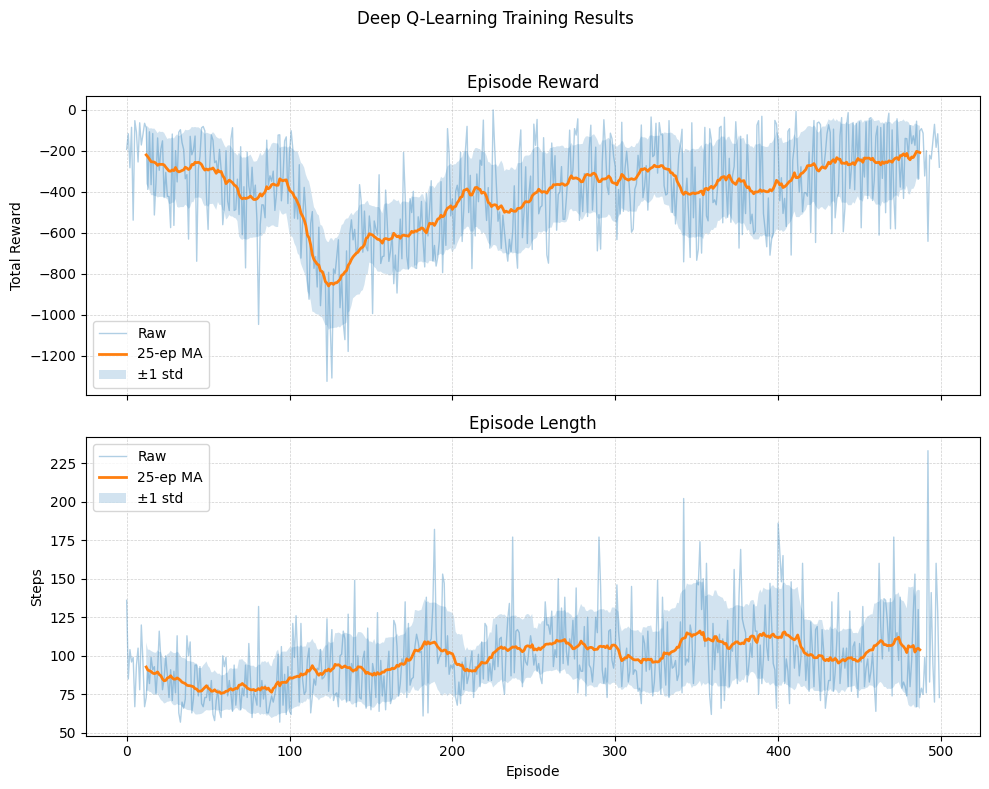

In [27]:
plot_training_statistics(
    episode_rewards=episode_rewards,
    episode_lengths=episode_lengths,
    title="Deep Q-Learning Training Results",
    save_path="deep_q_learning_training_results",
    window=25,
)

In [28]:
from model_saver import save_model_pytorch, save_lunar_model_onnx

# Save Network to Disk
# We will save target_q network as that is what we were training indirectly
save_model_pytorch(policy_net, "trained_networks_lunar_lander/deep_q_network_lunar_lander")

# save_lunar_model_onnx(target_q, "trained_networks_lunar_lander/deep_q_network_lunar_lander")

✅ Model weights saved to /Users/ibad/Desktop/ft_productivity_helpers/RL_Learn/trained_networks_lunar_lander/deep_q_network_lunar_lander_2025-09-27_08-34.pth
